## GA 적용을 위해 deap package 튜토리얼 진행

### 1. basic GA

[Reference] https://deap.readthedocs.io/en/0.9.2/tutorials/index.html

In [3]:
"""
1. Types
 By using 'creator', appropriate type for your problem
 
- base.Fitness의 attribute
    1) valid: Assess if a fitness is valid or not.
    2) values: Fitness values. Use directly individual.fitness.values
    3) weights = None
        The weights are used in the fitness comparison.
        => negative weight element corresponds to the minimization fo the associated objective
           and positive weight to the maximization
"""
from deap import base, creator

# Creates a new class named name inheriting from base in the creator module.
creator.create('FitnessMin', base.Fitness, weights=(-1.0, ))  # name, base (class), attribute
creator.create('Individual', list, fitness=creator.FitnessMin)
# => Individual.fitness attribute에 위에서 만든 FitnessMin이 들어감. (base.Fitness 클래스를 inherit)

# [참고] https://deap.readthedocs.io/en/0.9.2/tutorials/types.html#creating-types
# creator.create("Individual", numpy.ndarray, typecode="d", fitness=creator.FitnessMax)

In [40]:
creator.FitnessMin.weights

(-1.0,)

In [49]:
creator.Individual

deap.creator.Individual

In [10]:
"""
2. Initialization
 Once the types are created you need to fill them with sometimes random values, sometime guessed ones.
... The 'Toolbox' is a container for tools of all sorts including initializers that can do what is needed of them.

 Below codes,
- to create the initializers for individuals containing random floating point numbers
- for a population that contains them.
"""

"""
This creates functions to initialize populations from individuals that are themselves initialized
with random float numbers.
The functions are registered in the toolbox with there default arguments under the given name.

[More 'Creating types'] Fitness, Individual, 
https://deap.readthedocs.io/en/0.9.2/tutorials/types.html#creating-types
"""

import random
from deap import tools

IND_SIZE = 10

toolbox = base.Toolbox()
# register(alias, method, argument ...)
#   Register a method in the toolbox under the name alias.
#   => toolbox.alias(가명)으로 해당 함수 접근 가능.
toolbox.register('attribute', random.random)

# tools.initRepeat(container, func)
#    - container: the type to put in the data from func
#    - func: the function that will be called n times to fill the container
#    - n: the number of times to repeat func
#    return 'An instance of the container filled with data from func.'
toolbox.register('individual', tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=IND_SIZE)
# => IND_SIZE 횟수만큼 toolbox.attribute method를 반복해서 container인 creator.Individual에 넣음
#    => 해당 container의 instance를 반환하는 함수인 'toolbox.individual'이 register됨.

# 앞서 만든 ,toolbox.individual 이라는, individual instance를 반환하는 함수를 이용하여
# population 을 만드는 method를 toolbox에 register함.

# container 는 list, func는 이전에 만들었던 toolbox.individual.
#   => toolbox.population은 intanec of container.
# 즉, toolbox.individual이 IND_SIZE만큼 담겨있는 population을 반환함.
toolbox.register('population', tools.initRepeat,
                 list, toolbox.individual)
# => (alias, method, method's argument-[initRepeat의 container는 list, func은 toolbox.individual])

In [33]:
"""
3. Operators
 Operators are just like initalizers, excepted that some are already implemented in the tools module.
"""

"""
- Note that fitness values must be iterable, that is why we return tuple in the evaluate function.
- The registered functions are renamed by the toolbox to allows genericity 
  so that the algorithm does not depend on operators name.
  
[More 'Next step toward evolution']  ## Mutation, Crossover, Seletion을 custom으로 정의할 때 활용 ##
https://deap.readthedocs.io/en/0.9.2/tutorials/next_step.html#next-step

[deap Operators table]
https://deap.readthedocs.io/en/master/api/tools.html
"""

# individual 에 랜덤 그래프?를 넣고,
# evaluate 에서 해당 랜덤그래프를 이용하여 하나의 stage를 만들고
# 해당 stage를 train 시키면 될 듯

# selection operator 에 selNSGA2() 도 있음

def evaluate(individual):
    # list 형식의 individual 객체를 받아서, sum을 return 함
    return sum(individual),   # => return tuple

# toolbox.mate(), toolbox.select() 등의 이름으로 해당 함수에 접근할 수 있음.
toolbox.register('mate', tools.cxTwoPoint)  # crossover
# => return A tuple of two individuals.
# Execute a two points crossover on the input individuals.
# The two individuals are modified 'in place'

toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=1, indpb=0.1)  # mutation
# => return A tuple of one individual
# This function applies a gaussian mutation of mean mu and standard deviation sigma on the input individual.

toolbox.register('select', tools.selTournament, tournsize=3)  # selection.
# => return A list of selected individuals.
# tools.selTournament의 arguement 중 torunsize는 미리 지정해줌

toolbox.register('evaluate', evaluate)

In [50]:
"""
4. Algorithms
 For the purpose of completeness we will develop the complete generational algorithm.
"""
# population 생성.  (toolbox.population은 creator.Individual n개를 담은 list를 반환. (=> population)
pop = toolbox.population(n=50)
CXPB, MUTPB, NGEN = 0.5, 0.2, 40

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
# (function, iterable) => 'iterable 객체인 pop' 내 individual 각각에 toolbox.evaluate 함수 적용
print("Initial minimum fitness:", min(fitnesses))

for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit


# NGEN 만큼 세대(generation) 반복
for g in range(NGEN):
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))  # len(pop) 만큼 select함.
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
    # offspring을 iterate하며, 각각 toolbox.clone 적용
    
    # Apply crossover and mutation on the offspring
    # crossover 나 mutation 적용한 individuals 는 .fitness.values를 삭제 후, 나중에 다시 계산해줌.
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    # crossover, mutation 적용된 individuals 는 fitness.values가 비어있으므로, 다시 계산해줌.
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # The population is entirely replaced by the offspring
    pop[:] = offspring
    
min_ind_fitness = min( list(map(toolbox.evaluate, pop)) )
print("Final minimum fitness:", min_ind_fitness)

Initial minimum fitness: (2.7721210608938773,)
Final minimum fitness: (-34.870576681792606,)


### 1-2. basic GA - One Max problem

[Reference] https://www.tutorialspoint.com/artificial_intelligence_with_python/artificial_intelligence_with_python_genetic_algorithms

- One max problem


integer vectors randomly filled with 0 and 1.
   =>  let our population evolve until one of its members contains only 1 and no 0 anymore.

In [1]:
import random
from deap import base, creator, tools

In [8]:
# Define fitness function
# len(individual) - abs(ind의 성분합 - target_sum)
def eval_func(individual):
    target_sum = 15
    return len(individual) - abs(sum(individual) - target_sum),

In [13]:
# create the toolbox with the right parameters
def create_toolbox(num_bits):
    creator.create('FitnessMax', base.Fitness, weights=(1.0, ))  # maximization
    creator.create('Individual', list, fitness=creator.FitnessMax)  # name, base (class), attribute
    
    # Initialize the toolbox
    toolbox = base.Toolbox()

    toolbox.register('attr_bool', random.randint, 0, 1)  # register(alias, method, argument ...)
    toolbox.register('individuals', tools.initRepeat,
                    creator.Individual, toolbox.attr_bool, num_bits)
    
    # tools.initRepeat(container, func)
    #   return 'An instance of the container filled with data from func.'
    toolbox.register('population', tools.initRepeat,
                    list, toolbox.individuals)    
    
    # evaluation
    toolbox.register('evaluate', eval_func)
    
    # crossover
    toolbox.register('mate', tools.cxTwoPoint)
    
    # mutation
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
    
    # selection
    toolbox.register('select', tools.selTournament, tournsize=3)
    
    return toolbox

In [22]:
num_bits = 45
toolbox = create_toolbox(num_bits)

random.seed(7)
population = toolbox.population(n=500)

CXPB, MUTPB, NGEN = 0.5, 0.2, 10
min_list = []
max_list = []
avg_list = []

print('\nEvolution process starts')

# initialize
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit
print('\nEvaluated', len(population), 'individuals')

# generations
for g in range(NGEN):
    print('\n- Generation', g)
    
    # select the next generation individuals
    offspring = toolbox.select(population, len(population))
    
    # clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
    
    # crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):  # offspring의 짝수번째(0, 2, ...)와 홀수번째(1, 3,...)
        if random.random() < CXPB:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    # mutation on the offspring
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values
            
    # evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    print('Evaluated', len(invalid_ind), 'individuals')
    
    # replace population with next generation individual
    population[:] = offspring
    
    
    # print the statistics for the current generations
    fits = [ind.fitness.values[0] for ind in population]
    length = len(population)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    print('\nMin =', min(fits), ', Max =', max(fits))
    print('Average =', round(mean, 2), ', Standard deviation =', round(std, 2))
    
    min_list.append(min(fits))
    max_list.append(max(fits))
    avg_list.append(mean)
    
print('\n- Evolution ends')

/usr/local/lib/python3.5/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Evolution process starts

Evaluated 500 individuals

- Generation 0
Evaluated 295 individuals

Min = 32.0 , Max = 45.0
Average = 40.29 , Standard deviation = 2.61

- Generation 1
Evaluated 292 individuals

Min = 34.0 , Max = 45.0
Average = 42.35 , Standard deviation = 1.91

- Generation 2
Evaluated 277 individuals

Min = 37.0 , Max = 45.0
Average = 43.39 , Standard deviation = 1.46

- Generation 3
Evaluated 321 individuals

Min = 39.0 , Max = 45.0
Average = 43.79 , Standard deviation = 1.18

- Generation 4
Evaluated 303 individuals

Min = 39.0 , Max = 45.0
Average = 44.0 , Standard deviation = 1.19

- Generation 5
Evaluated 292 individuals

Min = 40.0 , Max = 45.0
Average = 44.07 , Standard deviation = 1.1

- Generation 6
Evaluated 283 individuals

Min = 39.0 , Max = 45.0
Average = 44.22 , Standard deviation = 1.11

- Generation 7
Evaluated 292 individuals

Min = 40.0 , Max = 45.0
Average = 44.15 , Standard deviation = 1.14

- Generation 8
Evaluated 296 individuals

Min = 39.0 , Max =

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

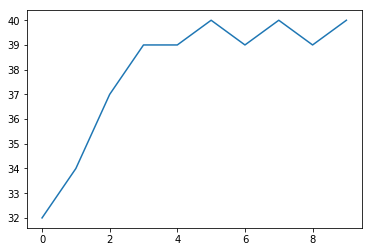

In [24]:
plt.plot(min_list)
plt.show()

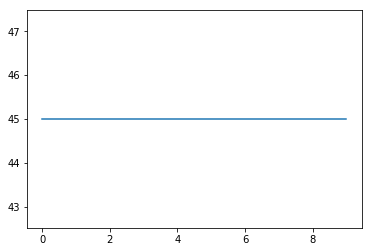

In [25]:
plt.plot(max_list)
plt.show()

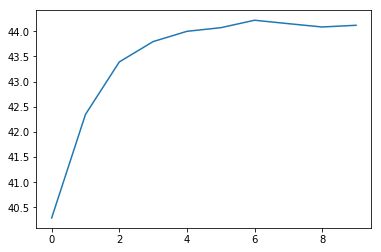

In [26]:
plt.plot(avg_list)
plt.show()